In [1]:
import cirq
import qiskit
import random
import numpy as np

from cirq.contrib.svg import SVGCircuit

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\qiskit\__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


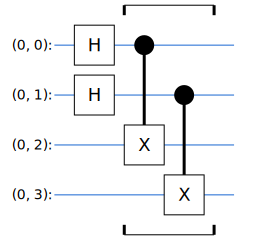

In [2]:
A1, A2, B, C = cirq.GridQubit.rect(1,4)

circuit = cirq.Circuit(
    cirq.H(A1), cirq.CNOT(control=A1, target=B),
    cirq.H(A2), cirq.CNOT(control=A2, target=C)
)


SVGCircuit(circuit)

In [5]:
def getCircuit(classical_bits):
    """
        getCircuit(circuit, ["01", "10"])
            => X(A1), Z(A2)
    """
    global circuit
    circuit_copy = circuit.copy()
    
    def operate(circuit, target, bits):
        if bits[0] == '1':
            circuit.append(cirq.Z(target))
        if bits[1] == '1':
            circuit.append(cirq.X(target))
        
        return circuit
    
    operate(circuit_copy, A1, classical_bits[0])
    operate(circuit_copy, A2, classical_bits[1])

    return circuit_copy

In [6]:
def buildU(p):
    matrixes = [
        cirq.unitary(cirq.I),cirq.unitary(cirq.X),
        cirq.unitary(cirq.Y),cirq.unitary(cirq.Z)
    ]
    
    U = np.zeros((4,4)).astype('complex128')
    pos = 0
    for i in range(4):
        for j in range(4):
            U += p[pos] * np.kron(matrixes[i], matrixes[j]).astype('complex128')
            pos += 1
            
    from qiskit.extensions import HamiltonianGate
    op = HamiltonianGate(U, 0.1)
    
    return op.to_matrix()

In [7]:
def generateRous(U, targets):
    bits = ["00", "01", "10", "11"]
    indexes = [0, 2] if targets == "AB" else [1, 3]
    rous = []
    
    from qiskit.quantum_info import partial_trace
    
    for i in range(4):
        for j in range(4):
            circuit = getCircuit([bits[i], bits[j]])
            circuit.append(cirq.ops.MatrixGate(U)(A1, A2))
            
            rous.append( partial_trace(cirq.unitary(circuit), indexes) )
    
    return rous

In [8]:
def sub_L(rou, sigma, loss_function):
    if loss_function == "F":
        # fidelity
        from cirq.qis import fidelity
        
        return fidelity(rou.data, sigma.data)
    
    elif loss_function == "D":
        # trace
        A = (rou - sigma)
        A = A.data
        tr = 0.5 * np.trace( (A.conj().T @ A) * 0.5 )
        
        return tr
    else:
        return 0

In [12]:
def L(bits, p, loss_function):
    U = buildU(p)
    rous_AB = generateRous(U, "AB")
    rous_AC = generateRous(U, "AC")
    
#     size = len(p)
    rou = rous_AB.pop(6)
    sigma = rous_AC.pop(6)
    
    loss = 0
    for r in rous_AB:
        loss += sub_L(rou, r, loss_function)
    for s in rous_AC:
        loss += sub_L(sigma, s, loss_function)
        
    loss = 0.5 * (1 / ((16 * 2 - 16)/2)) * loss
    if loss_function == "F":
        loss *= -1
    
    return loss

In [11]:
def GradientCalculator(bits, p, epsilon, loss_function):
    derivates = np.zeros(len(p))
    
    for i, param in enumerate(p):
        p[i] += epsilon
        l_pe = L(bits, p, loss_function)
        p[i] -= epsilon
        l_p = L(bits, p, loss_function)
        
        derivates[i] = (l_pe - l_p) / epsilon
        
#     print(derivates)
    return derivates

In [13]:
params = []

def SDCLearner(n, *, loss_function="D", epoch=1000, epsilon=0.01):
    # 1. initialize the parameters with uniformly random nunbers
    size = 2 ** (2 * n)
    bits = ["01", "10"]
    p = np.random.uniform(-1, 1, size)
    
    # Adam parameters:
    momentum, s = 0, 0
    alpha = 0.001
    belta1 = 0.9; belta2 = 0.999
    e = 1e-8
    
    global params
    
    t = 0
    while t < epoch:
        # repeat
        t += 1
        grad = GradientCalculator(bits, p, epsilon, loss_function)
        
        momentum = belta1 * momentum - (1 - belta1) * grad
        s = belta2 * s + (1 - belta2) * (grad * grad)
        m_ = momentum / (1 - belta1)
        s_ = s / (1 - belta2)

        p = p - alpha * (m_ / ( (s_ + e) ** 0.5 ))
        print('epoch: [{}/{}] - end.'.format(t, epoch))
    
    params = p

SDCLearner(2)

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


epoch: [1/1000] - end.
epoch: [2/1000] - end.
epoch: [3/1000] - end.
epoch: [4/1000] - end.
epoch: [5/1000] - end.
epoch: [6/1000] - end.
epoch: [7/1000] - end.
epoch: [8/1000] - end.
epoch: [9/1000] - end.
epoch: [10/1000] - end.
epoch: [11/1000] - end.
epoch: [12/1000] - end.
epoch: [13/1000] - end.
epoch: [14/1000] - end.
epoch: [15/1000] - end.
epoch: [16/1000] - end.
epoch: [17/1000] - end.
epoch: [18/1000] - end.
epoch: [19/1000] - end.
epoch: [20/1000] - end.
epoch: [21/1000] - end.
epoch: [22/1000] - end.
epoch: [23/1000] - end.
epoch: [24/1000] - end.
epoch: [25/1000] - end.
epoch: [26/1000] - end.
epoch: [27/1000] - end.
epoch: [28/1000] - end.
epoch: [29/1000] - end.
epoch: [30/1000] - end.
epoch: [31/1000] - end.
epoch: [32/1000] - end.
epoch: [33/1000] - end.
epoch: [34/1000] - end.
epoch: [35/1000] - end.
epoch: [36/1000] - end.
epoch: [37/1000] - end.
epoch: [38/1000] - end.
epoch: [39/1000] - end.
epoch: [40/1000] - end.
epoch: [41/1000] - end.
epoch: [42/1000] - end.
e

epoch: [334/1000] - end.
epoch: [335/1000] - end.
epoch: [336/1000] - end.
epoch: [337/1000] - end.
epoch: [338/1000] - end.
epoch: [339/1000] - end.
epoch: [340/1000] - end.
epoch: [341/1000] - end.
epoch: [342/1000] - end.
epoch: [343/1000] - end.
epoch: [344/1000] - end.
epoch: [345/1000] - end.
epoch: [346/1000] - end.
epoch: [347/1000] - end.
epoch: [348/1000] - end.
epoch: [349/1000] - end.
epoch: [350/1000] - end.
epoch: [351/1000] - end.
epoch: [352/1000] - end.
epoch: [353/1000] - end.
epoch: [354/1000] - end.
epoch: [355/1000] - end.
epoch: [356/1000] - end.
epoch: [357/1000] - end.
epoch: [358/1000] - end.
epoch: [359/1000] - end.
epoch: [360/1000] - end.
epoch: [361/1000] - end.
epoch: [362/1000] - end.
epoch: [363/1000] - end.
epoch: [364/1000] - end.
epoch: [365/1000] - end.
epoch: [366/1000] - end.
epoch: [367/1000] - end.
epoch: [368/1000] - end.
epoch: [369/1000] - end.
epoch: [370/1000] - end.
epoch: [371/1000] - end.
epoch: [372/1000] - end.
epoch: [373/1000] - end.


epoch: [662/1000] - end.
epoch: [663/1000] - end.
epoch: [664/1000] - end.
epoch: [665/1000] - end.
epoch: [666/1000] - end.
epoch: [667/1000] - end.
epoch: [668/1000] - end.
epoch: [669/1000] - end.
epoch: [670/1000] - end.
epoch: [671/1000] - end.
epoch: [672/1000] - end.
epoch: [673/1000] - end.
epoch: [674/1000] - end.
epoch: [675/1000] - end.
epoch: [676/1000] - end.
epoch: [677/1000] - end.
epoch: [678/1000] - end.
epoch: [679/1000] - end.
epoch: [680/1000] - end.
epoch: [681/1000] - end.
epoch: [682/1000] - end.
epoch: [683/1000] - end.
epoch: [684/1000] - end.
epoch: [685/1000] - end.
epoch: [686/1000] - end.
epoch: [687/1000] - end.
epoch: [688/1000] - end.
epoch: [689/1000] - end.
epoch: [690/1000] - end.
epoch: [691/1000] - end.
epoch: [692/1000] - end.
epoch: [693/1000] - end.
epoch: [694/1000] - end.
epoch: [695/1000] - end.
epoch: [696/1000] - end.
epoch: [697/1000] - end.
epoch: [698/1000] - end.
epoch: [699/1000] - end.
epoch: [700/1000] - end.
epoch: [701/1000] - end.


epoch: [990/1000] - end.
epoch: [991/1000] - end.
epoch: [992/1000] - end.
epoch: [993/1000] - end.
epoch: [994/1000] - end.
epoch: [995/1000] - end.
epoch: [996/1000] - end.
epoch: [997/1000] - end.
epoch: [998/1000] - end.
epoch: [999/1000] - end.
epoch: [1000/1000] - end.


In [14]:
params

array([ 0.01582897, -0.27174117,  0.40245615, -1.15137521,  1.47279292,
       -1.20539867,  0.11732657, -0.97726707, -1.1839263 ,  0.68715609,
        0.17663543,  1.5201344 , -1.32550229,  0.82466927,  1.61649694,
        1.54534631])

In [15]:
buildU(params)

array([[ 0.96031136+0.08677763j, -0.15727003-0.0914257j ,
        -0.02057921-0.0725707j , -0.08623596+0.15508892j],
       [ 0.22856262-0.01624983j,  0.89299848+0.16494118j,
        -0.07631194+0.11240413j,  0.21441912-0.24168044j],
       [ 0.04311023-0.02310721j,  0.03041292+0.07975324j,
         0.96938475+0.13471977j,  0.15043891+0.09916636j],
       [ 0.0628764 +0.10686878j, -0.29520645-0.21868524j,
        -0.0787735 +0.10858323j,  0.83139596-0.37475422j]])

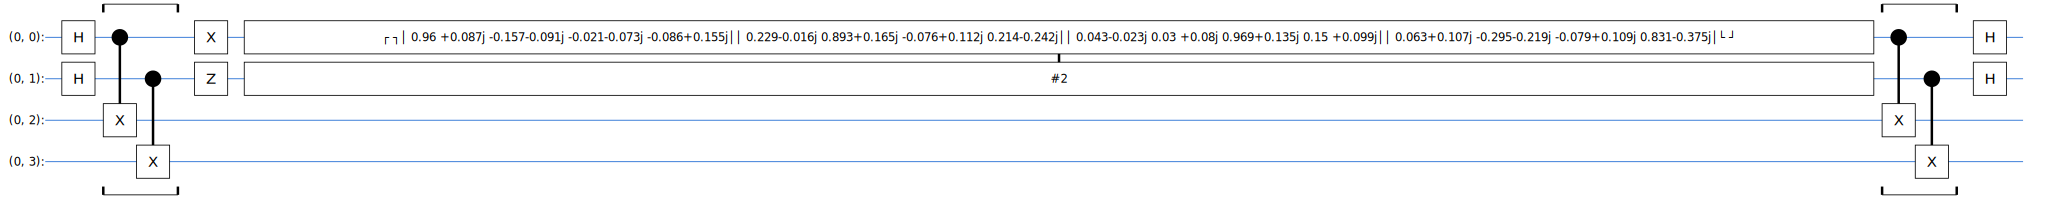

In [16]:
circuit_test = getCircuit(["01", "10"])
circuit_test.append(cirq.ops.MatrixGate(buildU(params))(A1, A2))

circuit_test.append([cirq.CNOT(control=A1, target=B), cirq.H(A1)])
circuit_test.append([cirq.CNOT(control=A2, target=C), cirq.H(A2)])

SVGCircuit(circuit_test)

In [17]:
circuit_test.append(cirq.measure(A1, B, key='A1B'))

sim = cirq.Simulator()
output = sim.run(circuit_test, repetitions=1000)
print(output.histogram(key="A1B"))

Counter({1: 862, 3: 73, 2: 33, 0: 32})


In [18]:
circuit_test.append(cirq.measure(A2, C, key='A2C'))

output = sim.run(circuit_test, repetitions=1000)
print(output.histogram(key="A2C"))

Counter({2: 876, 0: 70, 3: 29, 1: 25})


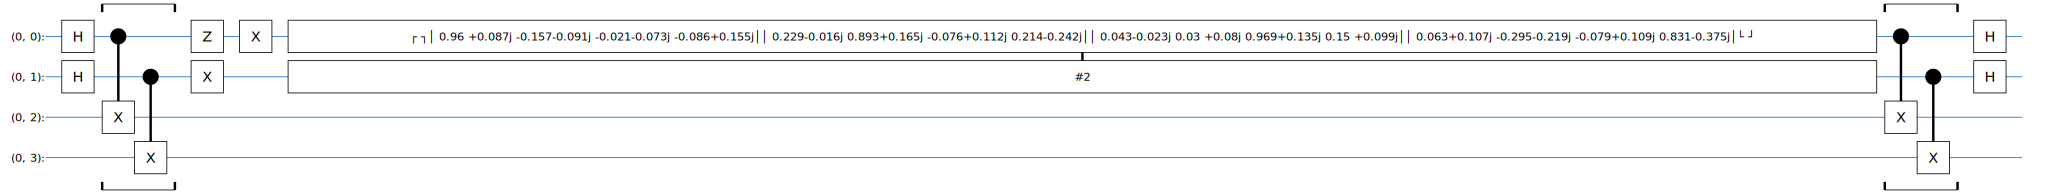

In [19]:
circuit_test2 = getCircuit(["11", "01"])
circuit_test2.append(cirq.ops.MatrixGate(buildU(params))(A1, A2))

circuit_test2.append([cirq.CNOT(control=A1, target=B), cirq.H(A1)])
circuit_test2.append([cirq.CNOT(control=A2, target=C), cirq.H(A2)])

SVGCircuit(circuit_test2)

In [20]:
circuit_test2.append(cirq.measure(A1, B, key='A1B'))

sim = cirq.Simulator()
output = sim.run(circuit_test2, repetitions=3000)
print(output.histogram(key="A1B"))

Counter({3: 2511, 1: 219, 2: 140, 0: 130})


In [21]:
circuit_test2.append(cirq.measure(A2, C, key='A2C'))

output = sim.run(circuit_test2, repetitions=3000)
print(output.histogram(key="A2C"))

Counter({1: 2637, 3: 217, 0: 76, 2: 70})
